# Emulator Development & Stress Testing

## Import Modules

In [ ]:
# General imports
import numpy as np
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib

# Data Handling
import xarray as xr
import pandas as pd

# Statistics
from scipy import stats 
from statsmodels.regression.linear_model import yule_walker

# Custom imports
import functions.helper as hlp
import functions.siametadata as meta
import functions.memberhandling as mbhl
import functions.emulator_func as em

## Load Data

In [2]:
basepath = "/Users/quraus001/Documents/Uni/SIA-Sensitivity-Uncertainty/"

datapath = basepath + "data/"
plotpath = basepath + "plots/Emulator/"

save_plots = False

In [3]:
# MPI-GE
df = mbhl.load_model_data(inpath=datapath + "MPI-ESM2-1-LR/sia_nh/", scenario="ssp245")
members = df.columns[:-3]

# CO2 Data
cmip6_ds = xr.open_dataset(datapath +"co2/CMIP6_co2_emissions_ssp.nc")
df_co2 = cmip6_ds.to_dataframe().cumsum(axis=0)
df_co2.index = df_co2.index.astype(int)

## Sketch

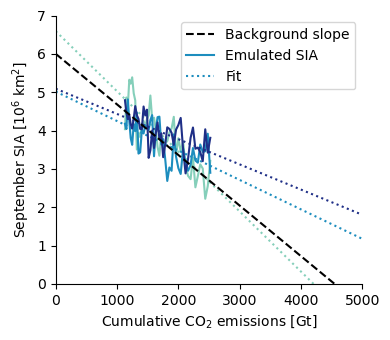

In [ ]:
np.random.seed(295)

observed_member = "r1i1p1f1"
num_members     = 3
noise           = "ar1"
true_slope      = -1.27

fig, ax = plt.subplots(1,tight_layout = True, figsize=(4,3.5))

colors = hlp.get_colors_from_colormap("YlGnBu", 4, stop=0.9, start=0.1)#YlGnBu copper

Sensitivities, background_dummy_sens, emulator_sia = em.experiment(observed_member, df_co2, df, num_members, noise, 1979, 2022, true_slope=true_slope, amplitude=0.42, ar1_corrcoef=0.4, co2_name="ssp245")

co2 = df_co2.loc[1979:2022]["ssp245"].values
background = np.arange(0,5000,10) * background_dummy_sens*1e-3 + 6

for i in range(num_members):
    sens, y_pred, lin_timing, intercept = meta.get_meta_data(emulator_sia[i,:], co2)
    y_pred = np.arange(0,5000,10) * sens*1e-3 + intercept
    ax.plot(co2, emulator_sia[i,:], color=colors[1+i])
    ax.plot(np.arange(0,5000,10), y_pred, linestyle=":", color=colors[1+i])
ax.plot(np.arange(0,5000,10), background, color="black", label="Background slope", linestyle="--")

ax.set_ylim(0,7)
ax.set_xlim(0,5000)
ax.set_xlabel("Cumulative CO$_2$ emissions [Gt]")
ax.set_ylabel("September SIA [$10^6$ km$^2$]")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(np.nan, np.nan, color=colors[-2], label="Emulated SIA")
ax.plot(np.nan, np.nan, linestyle=":", color=colors[-2], label="Fit")

ax.legend()

hlp.save_plot(plotpath + "Emulator-sketch", save_plots=save_plots, file_types=["png", "pdf"])

## AR(1) Coefficient Estimator

In [ ]:
def create_boxplot(ax, values, xpos, width, facecolor="navy", median_color="navy", alpha=0.2):

    bp = ax.boxplot(values, positions=[xpos], widths=[width], patch_artist=True)

    for patch in bp['boxes']:
        patch.set(facecolor = facecolor, alpha=alpha)# "#B1C9F5"

    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color = median_color)

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='.',
                color ='#e7298a',
                alpha = 0.2)

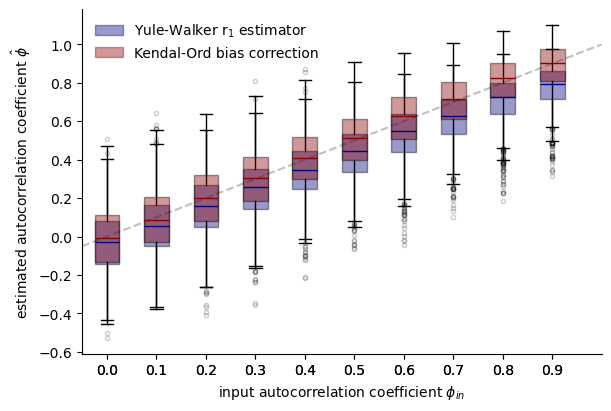

In [9]:
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(6,4))

ar1_coef    = 0.4 
variability = 0.4 # standard deviation
T = 40   # Length of the time series
N = 1000 # Number of noisy time series


for ar1_coef in np.arange(0,1,0.1):
    Phi1 = []
    Phi2 = []
    for i in range(N):
        ar1_noise  = em.create_ar1_noise(T, variability, ar1_coef)
        phi, sigma = yule_walker(ar1_noise, order=1)
        phi = phi[0]
        Phi1.append(phi)
        Phi2.append(phi + (1 + 4 * phi)/ T)

    create_boxplot(ax, Phi1, ar1_coef, 0.05)
    create_boxplot(ax, Phi2, ar1_coef, 0.05, facecolor="darkred", median_color="darkred")

ax.axline((0, 0), slope=1,color="gray",zorder=0,alpha=0.5, linestyle="--")
ax.set_xlim(-0.05,1)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:.1f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("estimated autocorrelation coefficient $\hat\phi$")
ax.set_xlabel("input autocorrelation coefficient $\phi_{in}$")


legend_elements = [Patch(color = "navy", label = "Yule-Walker r$_1$ estimator", alpha = 0.4),
                   Patch(color = "darkred", label = "Kendal-Ord bias correction", alpha=0.4)]

lgd = ax.legend(handles = legend_elements, frameon = False)#, bbox_to_anchor=(0.87,0.42), ncol = 1
hlp.save_plot(plotpath + "EM_phi-estimator", save_plots, ["png","pdf"])


## Emulator

In [5]:
names = {"sens":"Sensitivity $\hat S$", "true_slope":"Sensitivity $S_{in}$ [m$^2$/t]",
         "ar1_corrcoef":"AR(1) coefficient $\phi_{in}$", 
         "num_members": "# of members", "var":"Standard Deviation $\hat\sigma$", 
         "ar1":"AR(1) coefficient $\hat\phi$", "amplitude":"Input standard deviation $\sigma_{in}$ [10$^6$km$^2$]",
         "end_year" : "Length of the time series",
         "first": "First ice-free timing"}# [years]

symbols = {"var":"$\hat\sigma$", "ar1":"$\hat\phi$", "sens":"$\hat S$", "first":"FIFT"}

units = {"sens":"m$^2$/t", "var":"10$^6$km$^2$", "ar1":"1", "first":"depends", "true_slope":"m$^2$/t"}

In [ ]:
from statsmodels.regression.linear_model import yule_walker

def analyze_emulator_members(loop_param, loop_values, noise="ar1", observed_member="r1i1p1f1",
                             num_members=100, ar1_corrcoef=0.5, amplitude=0.4, true_slope=-1.4, N=10, hist="sens", input_line=True,
                             start_year=1979, end_year=2022):
    """
    Function to analyze the emulator members by looping over one specified parameter.

    Parameters:
    - loop_param: str, the parameter to loop over ('num_members', 'true_slope', 'amplitude', or 'ar1_corrcoef')
    - loop_values: list or array of values to loop through
    - noise: str, type of noise
    - observed_member: str, observed member name
    - num_members: int, number of members (default value if not looping over this parameter)
    - ar1_corrcoef: float, AR1 correlation coefficient (default value if not looping over this parameter)
    - amplitude: float, amplitude (default value if not looping over this parameter)
    - true_slope: float, true slope (default value if not looping over this parameter)
    - N: int, number of iterations for each parameter value
    """
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3.5*3, 3))

    # Define parameter mapping for ease of access
    param_map = {
        'num_members': num_members,
        'true_slope': true_slope,
        "sens": true_slope,
        "var" : amplitude,
        'amplitude': amplitude,
        'ar1_corrcoef': ar1_corrcoef,
        'ar1': ar1_corrcoef,
        "end_year" : end_year,
    }

    # Loop over the specified parameter
    for value in tqdm(loop_values, leave=True):
        Skews = []
        Kurtosis = []
        Mean = []

        # Update the parameter for the current loop
        params = {
            "df" : df,
            "df_co2":df_co2,
            "num_members": num_members,
            "noise": noise,
            "true_slope": true_slope,
            "amplitude": amplitude,
            "ar1_corrcoef": ar1_corrcoef,
            "observed_member": observed_member,
            "start_year": start_year,
            "end_year": end_year,
            "co2_name": "ssp245"
        }
        params[loop_param] = value

        if loop_param == "end_year":
            end_year = start_year + value
            params["end_year"] = end_year
            
        if not hist in ["sens", "first"]:
            params["dataframe"] = True


        for _ in range(N):

            if hist == "sens":
                Data = em.create_emulator_members(**params)
                
            elif hist in ["var", "ar1"]:
                Data = []
                df_dummy, Sensitivities = em.create_emulator_members(**params)
                for member in df_dummy.columns:
                    sia = df_dummy[member].loc[start_year : end_year].values
                    co2 = df_co2["ssp245"].loc[start_year : end_year].values
                    sens, y_pred, lin_timing, intercept = meta.get_meta_data(sia, co2)

                    residuals = df_dummy[member].loc[start_year:end_year] - y_pred

                    if hist == "var":
                        Data.append(np.std(residuals))
                    else:
                        # Estimate AR parameters using Yule-Walker equations
                        rho, sigma = yule_walker(residuals, order=1)
                        ar1_coef = rho[0] # em.find_ar1_corrcoef_new(residuals)
                        ar1_coef = ar1_coef + ((1+4*ar1_coef)/len(residuals))
                        Data.append(ar1_coef)

            Skews.append(stats.skew(Data))
            Kurtosis.append(stats.kurtosis(Data))
            Mean.append(np.mean(Data))

        # Plot results
        create_boxplot(ax2, Skews, value, np.max(abs(loop_values))/(len(loop_values)*2), facecolor="#B1C9F5", median_color="navy", alpha=1)
        create_boxplot(ax3, Kurtosis, value, np.max(abs(loop_values))/(len(loop_values)*2), facecolor="#B1C9F5", median_color="navy", alpha=1)
        create_boxplot(ax1, Mean, value, np.max(abs(loop_values))/(len(loop_values)*2), facecolor="#B1C9F5", median_color="navy", alpha=1)
    

    # Plot formatting
    fig.suptitle(f"Estimated {names[hist]} Distribution Characteristics", fontweight="bold")
    ax2.set_ylabel(f"Skewness of {symbols[hist]} dist.")
    ax3.set_ylabel(f"Kurtosis of {symbols[hist]} dist.")
    if input_line:
        ax1.axhline(y=param_map[hist], color="grey", linestyle="--")
    ax1.set_ylabel(f"Mean of {symbols[hist]} dist. [{units[hist]}]")
    ax1.set_xlabel(names[loop_param])
    
    for ax in [ax2, ax3]:
        ax.set_xlabel(names[loop_param])
        ax.axhline(y=0, color="grey", linestyle="--")

    diff = loop_values[1] - loop_values[0] 
    for ax, letter in zip([ax1, ax2, ax3],["A","B","C"]):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(loop_values[0] - diff*0.75, loop_values[-1] + diff*0.75)
        
        ax.set_xticks(loop_values[::2],loop_values[::2])
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
        if not loop_param == "num_members":
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:.1f}"))

        # Add subplot letters
        left, bottom, width, height = (0.91, 0.91, 0.11, 0.11)
        rect = plt.Rectangle((left, bottom), width, height,
                            facecolor="white", alpha=0.5, transform=ax.transAxes, zorder=9)

        ax.add_patch(rect)
        ax.text(.95, .95, letter, fontweight="bold", transform=ax.transAxes, fontsize=12, zorder=10)
        
    plt.tight_layout()
    return fig, (ax1, ax2, ax3)

100%|██████████| 9/9 [00:54<00:00,  6.05s/it]


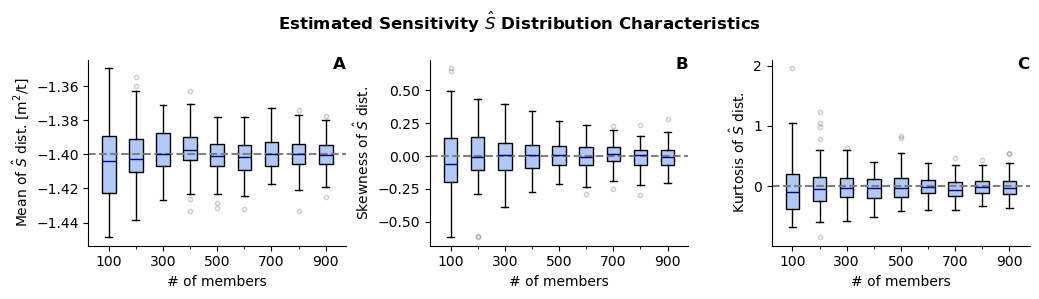

In [38]:
fig, axs = analyze_emulator_members(loop_param='num_members', loop_values=np.arange(100, 1000, 100), N=100, hist="sens")

hlp.save_plot(file_path=plotpath + "EM-stress-test_hist-sens_loop-num", save_plots=save_plots, file_types=["png", "pdf"])

100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


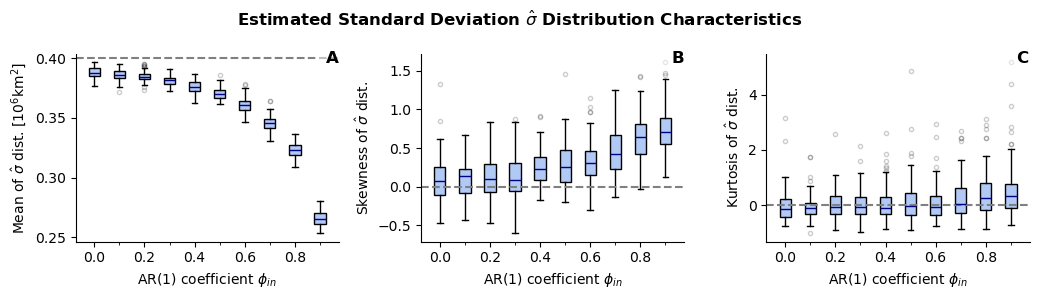

In [39]:
fig, axs = analyze_emulator_members(loop_param='ar1_corrcoef', loop_values=np.arange(0, 1, 0.1), N=100, hist="var", noise="ar1", 
                                    num_members=100, start_year=1979, end_year=2022)

hlp.save_plot(file_path=plotpath + "EM-stress-test_hist-var_loop-ar1", save_plots=save_plots, file_types=["png", "pdf"])

100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


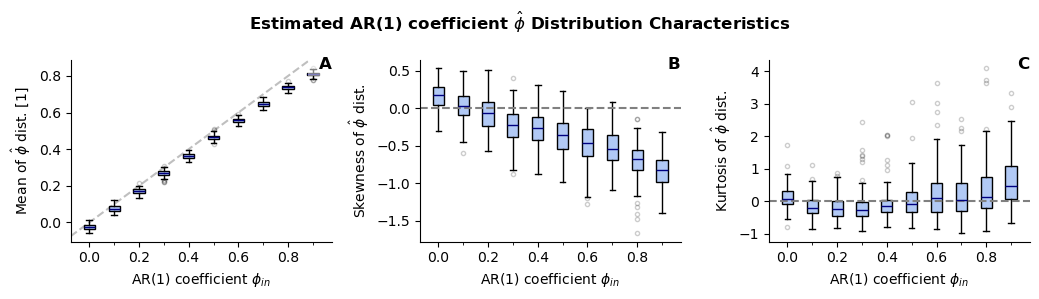

In [40]:
fig, (ax1, ax2, ax3) = analyze_emulator_members(loop_param='ar1_corrcoef', loop_values=np.arange(0, 1, 0.1), N=100, hist="ar1", noise="ar1", num_members=100, input_line=False)
ax1.axline((0, 0), slope=1,color="gray",zorder=0,alpha=0.5, linestyle="--")

hlp.save_plot(file_path=plotpath + "EM-stress-test_hist-ar1_loop-ar1", save_plots=save_plots, file_types=["png", "pdf"])

100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


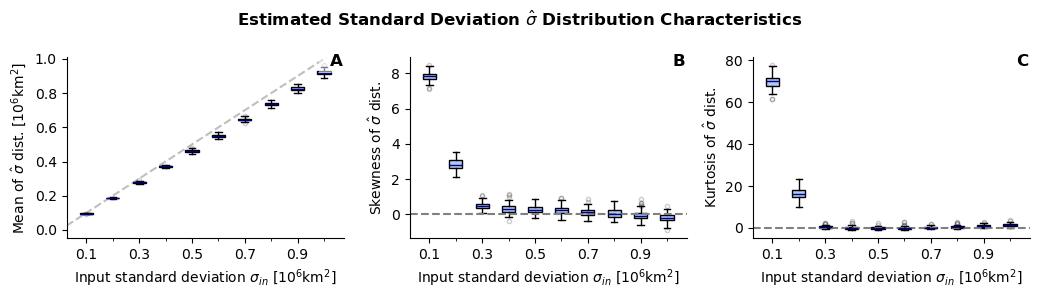

In [41]:
fig, (ax1, ax2, ax3) = analyze_emulator_members(loop_param='amplitude', loop_values=np.arange(0.1, 1.1, 0.1), N=100, hist="var", noise="ar1", num_members=100, input_line=False)
ax1.axline((0, 0), slope=1,color="gray",zorder=0,alpha=0.5, linestyle="--")

hlp.save_plot(file_path=plotpath + "EM-stress-test_hist-var_loop-var", save_plots=save_plots, file_types=["png", "pdf"])

100%|██████████| 9/9 [00:25<00:00,  2.82s/it]


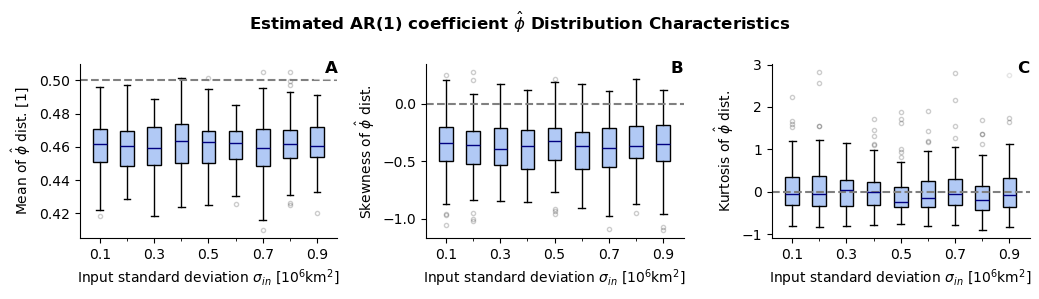

In [42]:
fig, (ax1, ax2, ax3) = analyze_emulator_members(loop_param='amplitude', loop_values=np.arange(0.1, 1, 0.1), N=100, hist="ar1", noise="ar1", num_members=100, input_line=True)

hlp.save_plot(file_path=plotpath + "EM-stress-test_hist-ar1_loop-var", save_plots=save_plots, file_types=["png", "pdf"])

100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


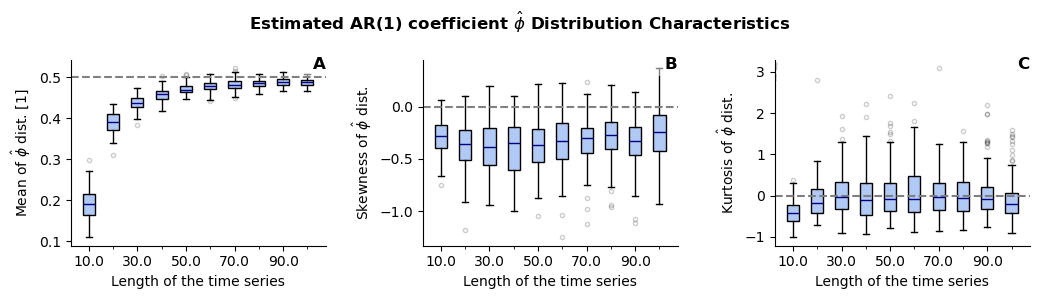

In [43]:
fig, (ax1, ax2, ax3) = analyze_emulator_members(loop_param='end_year', loop_values=np.arange(10, 110, 10), N=100, hist="ar1", noise="ar1", num_members=100)
ax3.axline((0, 0), slope=1,color="gray",zorder=0,alpha=0.5, linestyle="--")

hlp.save_plot(file_path=plotpath + "EM-stress-test_hist-ar1_loop-time", save_plots=save_plots, file_types=["png", "pdf"])

100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


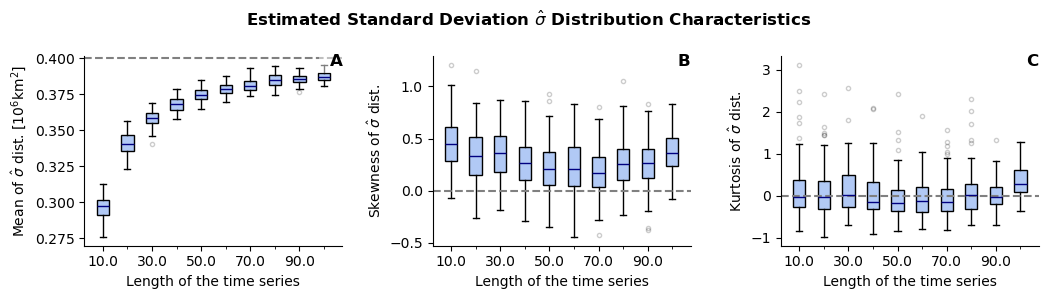

In [ ]:
fig, (ax1, ax2, ax3) = analyze_emulator_members(loop_param='end_year', loop_values=np.arange(10, 110, 10), N=100, hist="var", noise="ar1", num_members=100)

hlp.save_plot(file_path=plotpath + "EM-stress-test_hist-var_loop-time", save_plots=save_plots, file_types=["png", "pdf"])